# Obliquity Calculation

**Steps for the obliquity calculation:**

* Preparationg of the data
* Calculating the azimuth between the points 
* Calculating the obliquity with the azimuth and the relative plate velocities

## Preparation of the data

First, we are importing the needed libraries:

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import shapely.geometry as geo
import math as math
from scipy import spatial
import pandas_bokeh
from bokeh.plotting import save
from bokeh.transform import linear_cmap
import matplotlib 

Then we are importing the data files:

In [2]:
# The plate velocities that are defining azimuth of the plate movement

velocities = pd.read_csv("./data/velocity/velocity_0.00Ma.tsv", sep="   ", engine = "python")

# Nodes of the trench that are used for the calculation

trench = pd.read_csv("./data/pointtrench/Trench_dist_05.csv")

# A shapefile of the South American Continent for a better visualization

america = gpd.read_file("./data/Continent/SouthAmerica.shp")


The velocities file is a total mess and needs to be cleaned:

In [3]:
velocities.head()

,Longitude,Unnamed: 1,Latitude,Unnamed: 3,Azimuth,Unnamed: 5,Velocity,Unnamed: 7,Plate
0,0.0,NaN,90.0,NaN,323.943896,NaN,1.6515,NaN,101
1,0.0,NaN,90.0,NaN,323.943896,NaN,1.6515,NaN,101
2,0.0,NaN,90.0,NaN,323.943896,NaN,1.6515,NaN,101
3,0.0,NaN,90.0,NaN,323.943896,NaN,1.6515,NaN,101
4,0.0,NaN,90.0,NaN,323.943896,NaN,1.6515,NaN,101


In [4]:
# Getting rid of the useless rows

velocities = velocities.drop(columns=['Unnamed: 1', 'Unnamed: 3', 'Unnamed: 5', 'Unnamed: 7'])

# Fixing the column names that are wrong because of the weird formatting 

velocities["Azimuth"] = velocities['  Azimuth']
velocities["Latitude"] = velocities["  Latitude"]
velocities["Plate"] = velocities['  Plate']
velocities["Velocity"] = velocities['  Velocity']

# Deleting the columns that have the wrong names

del velocities['  Azimuth']
del velocities['  Latitude']
del velocities['  Plate']
del velocities['  Velocity']

Better:

In [5]:
velocities.head()

,Longitude,Azimuth,Latitude,Plate,Velocity
0,0.0,323.943896,90.0,101,1.6515
1,0.0,323.943896,90.0,101,1.6515
2,0.0,323.943896,90.0,101,1.6515
3,0.0,323.943896,90.0,101,1.6515
4,0.0,323.943896,90.0,101,1.6515


The velocities that we need are the ones with a plate ID of 910 or 911:

In [6]:
nazca_velocities = velocities.loc[(velocities['Plate']==910) | 
                                        (velocities['Plate']==911)]

For Geopandas we need geodataframes of the velocities and the trench:

In [7]:
# Creates a geodataframe for the velocities

gdf_velocities = gpd.GeoDataFrame(nazca_velocities, 
                                  geometry = [geo.Point(x,y) for x,y in zip(nazca_velocities.Longitude, nazca_velocities.Latitude)])

# Cuts off velocities that are too far north

gdf_velocities = gdf_velocities[gdf_velocities.Latitude < 10]

# Creates a geodataframe of the trench

gdf_trench = gpd.GeoDataFrame(trench, geometry = [geo.Point(x,y) for x,y in zip(trench.X, trench.Y)])

# Reverses the order of the trench geodataframe

gdf_trench = gdf_trench.iloc[::-1]

# Cuts the geodataframe at the tail and only keeps the first 1300 rows

gdf_trench =  gdf_trench.head(1300)

# Cuts away the beginning part of the trench that is not part of the Nazca subduction

gdf_trench = gdf_trench.iloc[120:]

Let's see how our trench and velocities are doing:

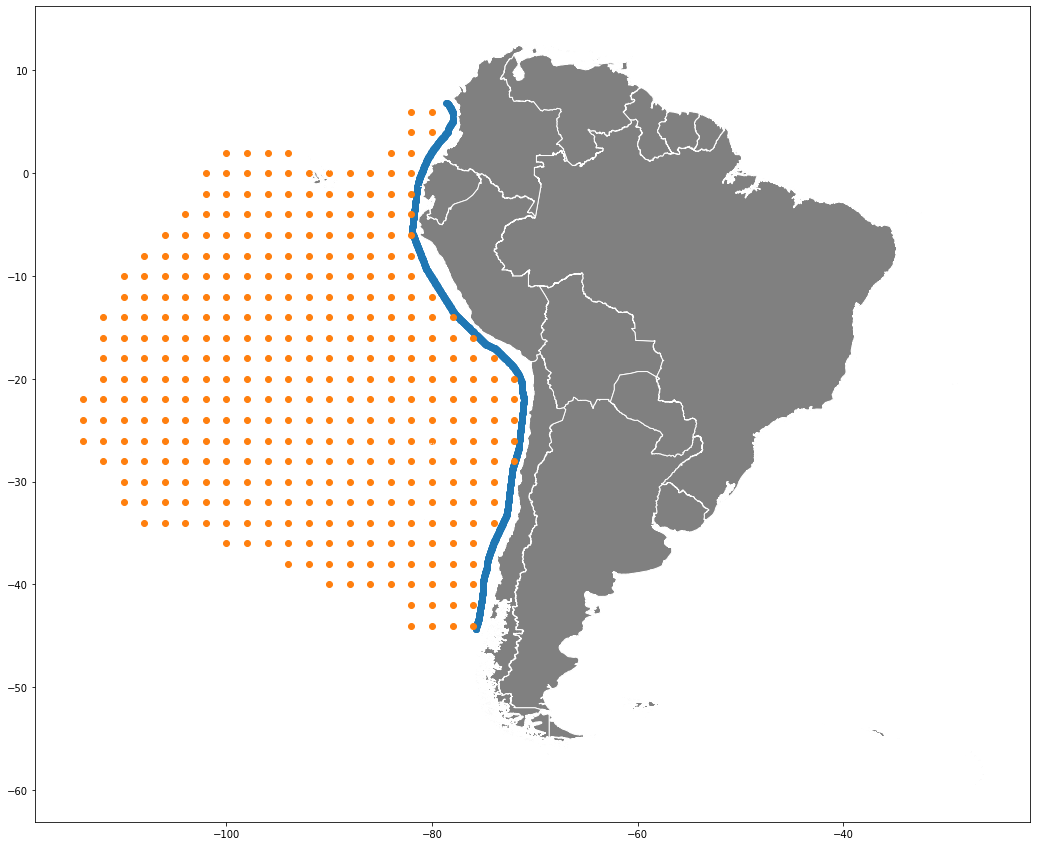

In [8]:
fig, ax = plt.subplots(figsize=(30,15))
ax.set_aspect('equal')

gdf_trench.plot(ax=ax)
gdf_velocities.plot(ax=ax)
america.plot(ax=ax, color='grey', edgecolor='white')

## Calculating the azimuth between the points 

**Explanation of the azimuth:**

The azimuth is the angle in which the point is pointing. For instance, an azimuth of 90° would indicate that the point is facing East. The Nazca plate is moving towards South America so the velocities have to be between 0° and 180°. 

The nodes of the South American trench span lines with their nearest point South of the trench. These lines have an azimuth as well. 

These azimuths can be used to calculate the obliquity along the trench.

<center><img src="img/south-america1.jpg" style="width: 250px;"></center>

In [9]:
# Calculating the azimuth of each line between the coordinates

azimuths = []
longtemp = 0
lattemp = 0

for longitude, latitude in zip(gdf_trench["X"], gdf_trench["Y"]):
    y = longitude - longtemp
    x = latitude - lattemp
    azimuth = 180 / math.pi * math.atan2(y, x)
    if azimuth < 0:
         azimuth = azimuth + 360
    azimuths.append(azimuth)
    longtemp = longitude
    lattemp = latitude

Because it is easier to project points for the specific azimuths, we will use the locations that are located in the middle of the coordiante pairs:

In [10]:
# Calculating the middle point of each pair of coordinates

latitudes = []
longitudes = []

for longitude, latitude in zip(gdf_trench["X"], gdf_trench["Y"]):
    m_longitude = ((longitude + longtemp)/2)
    m_latitude = ((latitude + lattemp)/2)
    longitudes.append(m_longitude)
    latitudes.append(m_latitude)
    longtemp = longitude
    lattemp = latitude

## Calculating the obliquity with the azimuth and the relative plate velocities

Now we have the coordinates and the azimuths of the trench. For calculating the obliquity, we assign the nearest velocity to our points on the trench. Luckily, there is a function in scipy.spatial that can do the work for us.

In [11]:
# Creating a 2D numpy array for our coordinates

nodes = np.c_[longitudes, latitudes]

# Creating a 2D numpy array for the velocity coordinates

velocities_coordinates = np.c_[nazca_velocities["Longitude"], nazca_velocities["Latitude"]]

# Creating a Scipy spatial KDtree
tree = spatial.KDTree(velocities_coordinates)

list = []
for node in nodes:
    tree = spatial.KDTree(velocities_coordinates)
    tree.query(node)[1]
    list.append(tree.query(node)[1])    

Now we have a list of the assigned velocities.

Calculating the obliquity is not that difficult. We just have to substract 90° from our azimuth of our trench and the azimuth of the velocities. To calculate the absolute value, we simply multiply the negative values with -1.

In [12]:
nazca_azimuths = nazca_velocities.values[:,1]

In [13]:
obliquities = []
nazca_azimuths_list = []

for azimuth, velocity in zip(azimuths, list):
    obliquity = azimuth - nazca_azimuths[velocity]-90
    #if obliquity < 0:
        #obliquity = obliquity * -1 
    obliquities.append(obliquity)
    nazca_azimuths_list.append(nazca_azimuths[velocity])

Now we can create a Pandas dataframe with our results:

In [14]:
df = pd.DataFrame({'Longitude':nodes[:,0], 
                   'Latitude':nodes[:,1],
                   'Vpoint':list, # Used velocity point
                   'Apoint': azimuths, # Azimuth of the line on the trench
                   'VAzimuth': nazca_azimuths_list, # Azimuth of the velocity that is used
                   'Obliquity':obliquities}) # the calculated obliquity

Mask out values that have an error:

In [15]:
df = df.loc[(df['Obliquity']<90)]

Create a Geopandas geodataframe:

In [16]:
gdf_obliquity = gpd.GeoDataFrame(df, geometry = [geo.Point(x,y) for x,y in zip(df.Longitude, df.Latitude)])

**And here are our plotted obliquities:**

Text(0.5, 1, 'Obliquities of the Nazca Subduction')

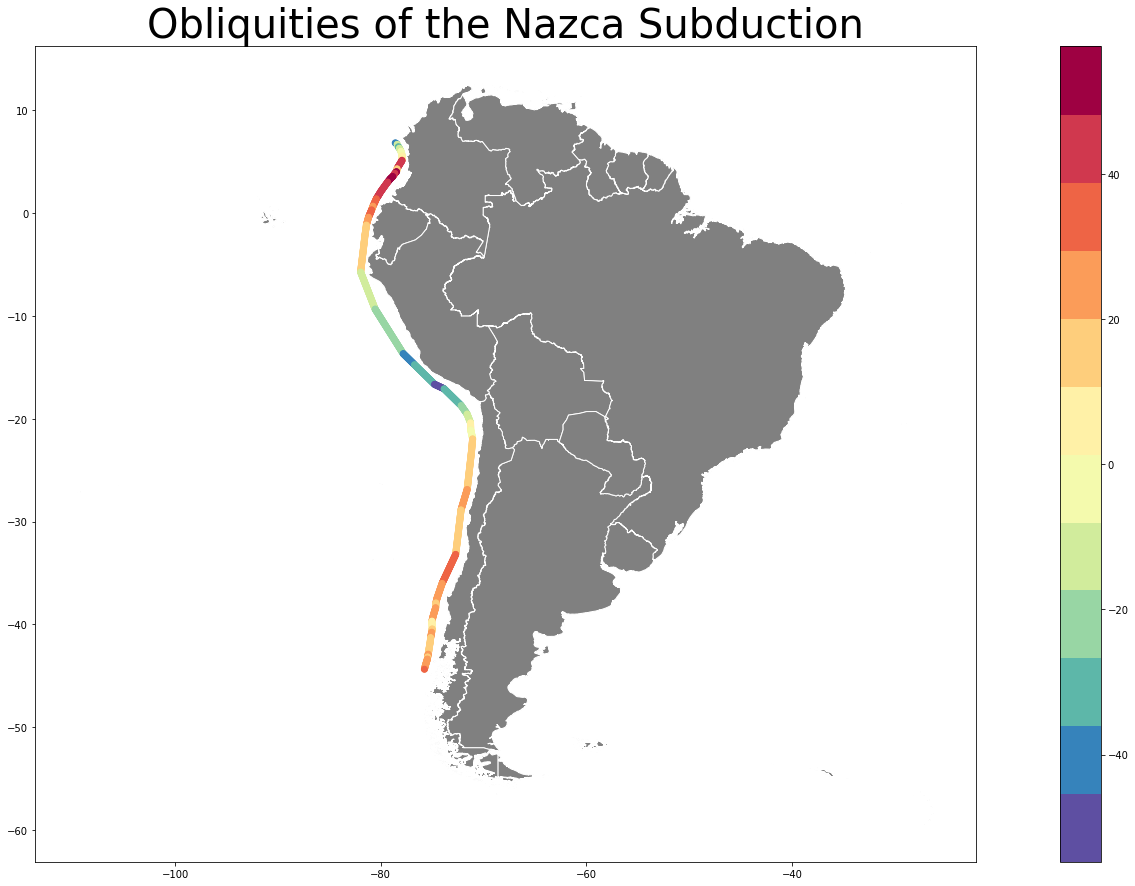

In [19]:
fig, ax = plt.subplots(figsize=(30,15))
ax.set_aspect('equal')

america.plot(ax=ax, color='grey', edgecolor='white')
gdf_obliquity.plot(ax=ax,column='Obliquity', cmap=plt.cm.get_cmap('Spectral_r', 12),legend=True)
plt.title("Obliquities of the Nazca Subduction", size =40)

Now we can save our geodataframe to pickle (fastest way of saving and reusing the data).

In [18]:
gdf_obliquity.to_pickle('./data/Obliquity')